# Using an external optimizer
Hazel comes with a preconfigured efficient Levenberg-Marquard algorithm, but it can also use any external optimizer. It can seamlessly integrate all SciPy optimizers but it also provides the tools to use other optimizers.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
from scipy.optimize import minimize, differential_evolution
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

2018.06.07


Let's start by generating a model by reading the following configuration file:

In [2]:
%cat conf_single.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 1

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Wavelength = 10826, 10833, 150
    Topology = ph1 -> ch1 -> te1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = 'observations/10830.wavelength'
    Wavelength weight file = 'observations/10830.weights'
    Observations file = 'observations/10830_stokes.1d'    
    Weights Stokes I = 1.0, 0.0, 0.0, 0.0
    Weights Stokes Q = 0.0, 0.0, 0.0, 0.0
    Weights Stokes U = 0.0, 0.0, 0.0, 0.0
    Weights Stokes V = 0.0, 0.0, 0.0, 0.0
    Mask

This is a very simple inversion in which only two variables are inverted. This is surely not realistic but serves for the purpose of showing how more complicated things can be done. Let's then read the configuration file and read the observation file defined in the configuration file.

In [10]:
# Test a single inversion in non-iterator mode
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()

2018-07-10 16:49:25,504 - Adding spectral region spec1
2018-07-10 16:49:25,506 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:49:25,511 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:49:25,519 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:49:25,520 -   - No mask for pixels
2018-07-10 16:49:25,522 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:49:25,524 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:49:25,526 - Using 1 cycles
2018-07-10 16:49:25,527 - Adding atmospheres
2018-07-10 16:49:25,529 -   - New available photosphere : ph1
2018-07-10 16:49:25,531 -     * Adding line : [300]
2018-07-10 16:49:25,532 -     * Magnetic field reference frame : vertical
2018-07-10 16:49:25,534 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:49:25,541 -   - New available chromosphere : ch1
2018-07-10 16:49:25,543 -     * Adding line : 10830

Next, let us invert it with the Levenberg-Marquartd algorithm provided by Hazel:

In [11]:
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-07-10 16:49:27,816 - -------------
2018-07-10 16:49:27,818 -   Cycle 0  
2018-07-10 16:49:27,819 -   Weights for region spec1 : SI=1.0 - SQ=0.0 - SU=0.0 - SV=0.0
2018-07-10 16:49:27,821 - -------------
2018-07-10 16:49:28,505 - It: 0 - chi2: 111.73449838540526 - lambda: 0.01827353919358589 - rel: -1.999999955306201
2018-07-10 16:49:28,999 - It: 1 - chi2: 94.98983501701414 - lambda: 0.0018273539193585883 - rel: -0.16199992611218303
2018-07-10 16:49:29,501 - It: 2 - chi2: 94.98411532156018 - lambda: 0.18273539193585883 - rel: -6.0215576333158097e-05


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


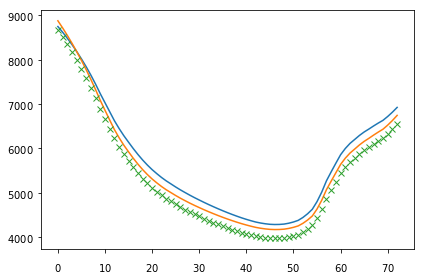

In [12]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

### Using SciPy

Then we open the output file, call `invert_external`, write the output and close it. `invert_external` allows the user to pass an SciPy optimizer and the arguments for the optimizer. The advantage of the SciPy optimizers is that they share the arguments. In this example, we'll use the Nelder-Mead algorithm, that does not use derivatives.

In [15]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, method='Nelder-Mead')
mod.write_output()
mod.close_output()

2018-07-10 16:50:34,398 - Adding spectral region spec1
2018-07-10 16:50:34,400 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:50:34,405 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:50:34,410 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:50:34,411 -   - No mask for pixels
2018-07-10 16:50:34,413 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:50:34,414 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:50:34,416 - Using 1 cycles
2018-07-10 16:50:34,417 - Adding atmospheres
2018-07-10 16:50:34,418 -   - New available photosphere : ph1
2018-07-10 16:50:34,420 -     * Adding line : [300]
2018-07-10 16:50:34,421 -     * Magnetic field reference frame : vertical
2018-07-10 16:50:34,423 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:50:34,428 -   - New available chromosphere : ch1
2018-07-10 16:50:34,430 -     * Adding line : 10830

Now we plot the results.

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


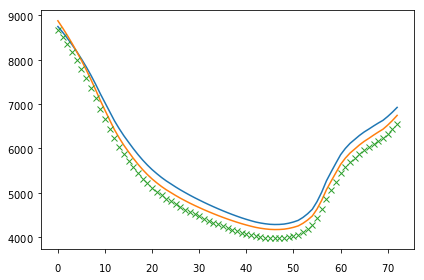

In [16]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

Now let's use an optimizer that uses first-order derivatives. Let's select the Newton-CG method:

In [17]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, use_jacobian=True, method='Newton-CG')
mod.write_output()
mod.close_output()

2018-07-10 16:50:45,019 - Adding spectral region spec1
2018-07-10 16:50:45,021 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:50:45,027 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:50:45,034 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:50:45,036 -   - No mask for pixels
2018-07-10 16:50:45,038 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:50:45,039 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:50:45,041 - Using 1 cycles
2018-07-10 16:50:45,043 - Adding atmospheres
2018-07-10 16:50:45,045 -   - New available photosphere : ph1
2018-07-10 16:50:45,046 -     * Adding line : [300]
2018-07-10 16:50:45,048 -     * Magnetic field reference frame : vertical
2018-07-10 16:50:45,050 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:50:45,057 -   - New available chromosphere : ch1
2018-07-10 16:50:45,059 -     * Adding line : 10830

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


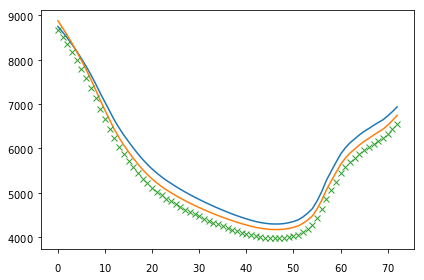

In [18]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

### Using other external optimizers (pro-mode)
Using non-SciPy optimizers is slightly more complicated. For this purpose Hazel provides the necessary tools to use them. Here we show an example using the well-known Adam optimizer, broadly used for training deep neural networks. It is a first-order optimizer which uses derivative information. Let us first define a class that implements the Adam optimizer:

In [19]:
class AdamOptimizer:
    def __init__(self, fun, x0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
        self.theta = x0
        self.fun = fun

    def optimize(self, n_iter):
        for i in range(n_iter):
            f, gradient = self.fun(self.theta)
            self.t = self.t + 1
            self.m = self.beta1*self.m + (1 - self.beta1)*gradient
            self.v = self.beta2*self.v + (1 - self.beta2)*(gradient**2)
            m_hat = self.m/(1 - self.beta1**self.t)
            v_hat = self.v/(1 - self.beta2**self.t)
            self.theta = self.theta - self.alpha*(m_hat/(np.sqrt(v_hat) - self.epsilon))
            print("Iter: {0} - chi2: {1}".format(self.t, f))
        return self.theta

Now we instantiate the model, read the observations and open the output. Next, we need to follow what `invert_external` does. First, compute some factors used internally by Hazel. Loop over all cycles with the following steps: i) find the active parameters, ii) instantiate the optimizer with the `_func_grad` function provided by Hazel, iii) call the optimizer, iv) set the final model and v) propagate the new parameters to the final ones. Finally, we write the output.

In [9]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()

for k, v in mod.spectrum.items():
    v.factor_chi2 = 1.0 / (v.noise**2 * v.dof)

for mod.cycle in range(mod.n_cycles):
    mod.find_active_parameters(mod.cycle)
    n_pars = len(mod.nodes)
    
    optimizer = AdamOptimizer(mod._func_grad, mod.nodes)
    
    tmp = optimizer.optimize(300)
    
    mod.set_new_model(tmp)

    mod.flatten_parameters_to_reference(mod.cycle)
    
mod.write_output()
mod.close_output()

2018-07-10 16:26:09,301 - Adding spectral region spec1
2018-07-10 16:26:09,303 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:26:09,307 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:26:09,312 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:26:09,314 -   - No mask for pixels
2018-07-10 16:26:09,316 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:26:09,317 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:26:09,319 - Using 1 cycles
2018-07-10 16:26:09,321 - Adding atmospheres
2018-07-10 16:26:09,322 -   - New available photosphere : ph1
2018-07-10 16:26:09,324 -     * Adding line : [300]
2018-07-10 16:26:09,325 -     * Magnetic field reference frame : vertical
2018-07-10 16:26:09,327 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:26:09,332 -   - New available chromosphere : ch1
2018-07-10 16:26:09,334 -     * Adding line : 10830

Iter: 1 - chi2: 126277.9102233025
Iter: 2 - chi2: 124377.27114700752
Iter: 3 - chi2: 122494.07327449096
Iter: 4 - chi2: 120625.7780454855
Iter: 5 - chi2: 118771.8889292491
Iter: 6 - chi2: 116931.83293481817
Iter: 7 - chi2: 115107.51264876325
Iter: 8 - chi2: 113298.09305335704
Iter: 9 - chi2: 111503.49877122015
Iter: 10 - chi2: 109725.03622975713
Iter: 11 - chi2: 107961.51609551997
Iter: 12 - chi2: 106214.52546300793
Iter: 13 - chi2: 104484.10229105297
Iter: 14 - chi2: 102769.28574917912
Iter: 15 - chi2: 101068.29069314834
Iter: 16 - chi2: 99386.97020157253
Iter: 17 - chi2: 97722.10206513092
Iter: 18 - chi2: 96074.15099471959
Iter: 19 - chi2: 94443.90822105575
Iter: 20 - chi2: 92830.51740820496
Iter: 21 - chi2: 91233.53354825314
Iter: 22 - chi2: 89654.84321052779
Iter: 23 - chi2: 88093.57054220757
Iter: 24 - chi2: 86549.43522450418
Iter: 25 - chi2: 85021.21978253477
Iter: 26 - chi2: 83512.39941832481
Iter: 27 - chi2: 82020.30531116106
Iter: 28 - chi2: 80547.0305263353
Iter: 29 - chi2: 7

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


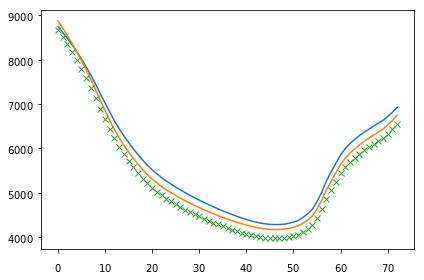

In [4]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()